In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import numpy as np


In [2]:

# **Device Setup**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True


Using device: cpu


In [3]:

# **Dataset Paths**
data_dir = 'ecg'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Train/Test directory not found!")


In [4]:

# **Preprocessing**
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [5]:

# **Load Training & Test Data**
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

batch_size = 16  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


In [6]:


# **Updated CNN Model**
class ECG_CNN(nn.Module):
    def __init__(self, num_classes):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  
        self.fc1 = nn.Linear(128, 64)  
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [7]:

# **Initialize Model**
num_classes = len(train_dataset.classes)
model = ECG_CNN(num_classes).to(device)


In [8]:

# **Loss and Optimizer**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [9]:

#
# **Training the Model**
num_epochs = 75 
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")


Epoch [1/75], Loss: 1.3659, Accuracy: 30.96%
Epoch [2/75], Loss: 1.3646, Accuracy: 31.62%
Epoch [3/75], Loss: 1.3650, Accuracy: 31.62%
Epoch [4/75], Loss: 1.3626, Accuracy: 31.62%
Epoch [5/75], Loss: 1.3631, Accuracy: 31.62%
Epoch [6/75], Loss: 1.3636, Accuracy: 31.62%
Epoch [7/75], Loss: 1.3627, Accuracy: 31.39%
Epoch [8/75], Loss: 1.3622, Accuracy: 31.62%
Epoch [9/75], Loss: 1.3638, Accuracy: 31.62%
Epoch [10/75], Loss: 1.3544, Accuracy: 32.29%
Epoch [11/75], Loss: 1.3129, Accuracy: 37.61%
Epoch [12/75], Loss: 1.2031, Accuracy: 42.54%
Epoch [13/75], Loss: 1.0945, Accuracy: 47.44%
Epoch [14/75], Loss: 1.0588, Accuracy: 49.62%
Epoch [15/75], Loss: 1.0378, Accuracy: 51.04%
Epoch [16/75], Loss: 0.9971, Accuracy: 55.34%
Epoch [17/75], Loss: 0.9738, Accuracy: 59.01%
Epoch [18/75], Loss: 0.9403, Accuracy: 61.26%
Epoch [19/75], Loss: 0.8589, Accuracy: 66.49%
Epoch [20/75], Loss: 0.8014, Accuracy: 69.37%
Epoch [21/75], Loss: 0.7389, Accuracy: 71.45%
Epoch [22/75], Loss: 0.6880, Accuracy: 72.9

In [23]:
 
    # **Save Best Model**
    if train_acc > best_acc:
        best_acc = train_acc
        torch.save(model.state_dict(), "best_ecg_cnn.pth")



Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       1.00      1.00      1.00       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.85      0.87      0.86       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.96      0.81      0.88       233
                          Normal Person ECG Images (284x12=3408)       0.90      1.00      0.95       284

                                                        accuracy                           0.93       928
                                                       macro avg       0.93      0.92      0.92       928
                                                    weighted avg       0.93      0.93      0.93       928


Confusion Matrix:


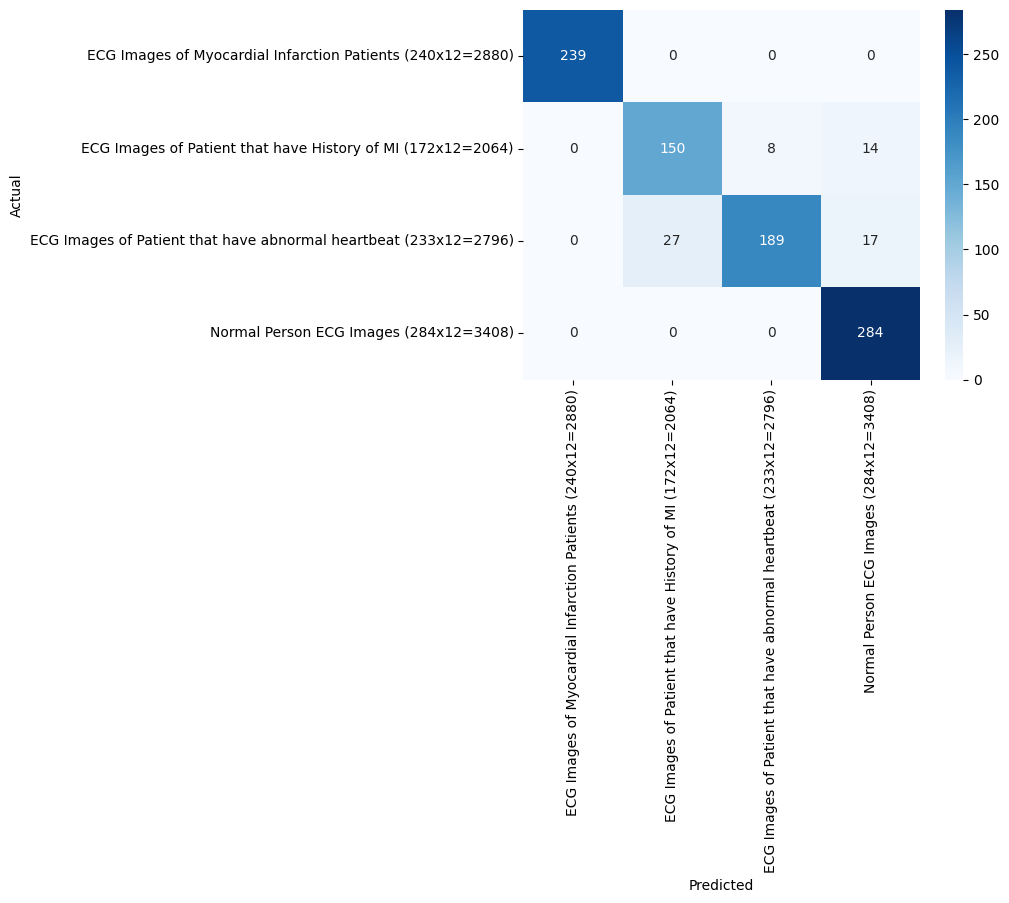

In [24]:
# Initialize lists to store labels and predictions
all_labels = []
all_preds = []

# Evaluate the model
model.eval()  
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())  # Store true labels
        all_preds.extend(predicted.cpu().numpy())  # Store predictions

# Convert lists to NumPy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# **Classification Report & Confusion Matrix**
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Enter the path of the ECG image:  ecg/test/ECG Images of Myocardial Infarction Patients (240x12=2880)/MI(1).jpg


C:\Users\HP\AppData\Local\Temp\ipykernel_14788\104991463.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_ecg_cnn.pth", map_locatio

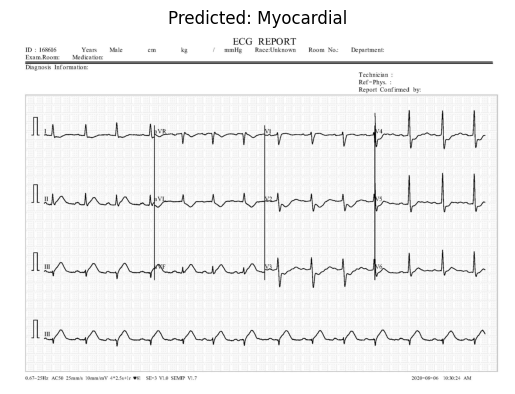

Predicted Disease: Myocardial


In [25]:
def predict_ecg_image(image_path):
    if not os.path.exists("best_ecg_cnn.pth"):
        raise FileNotFoundError("Trained model file 'best_ecg_cnn.pth' not found!")

    # Load the trained PyTorch model
    model.load_state_dict(torch.load("best_ecg_cnn.pth", map_location=device))
    model.to(device)
    model.eval()

    # Preprocess the input image
    img = Image.open(image_path).convert("L")  # Convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    # Make prediction
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted_class = torch.max(output, 1)

    class_labels = {0: "Myocardial", 1: "MI", 2: "Abnormal Heart Beat", 3: "Normal"}
    result = class_labels.get(predicted_class.item(), "Unknown")

    plt.imshow(img, cmap="gray")
    plt.title(f"Predicted: {result}")
    plt.axis("off")
    plt.show()

    print(f"Predicted Disease: {result}")
    return result

if __name__ == "__main__":
    image_path = input("Enter the path of the ECG image: ").strip()
    if os.path.exists(image_path):
        predict_ecg_image(image_path)
    else:
        print("Error: Image path does not exist!")


In [26]:
def check_accuracy(model, data_loader, device, dataset_type="Test"):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get the class with highest probability
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"{dataset_type} Accuracy: {accuracy:.2f}%")
    return accuracy

# *Check Accuracy for Training and Test Data*
train_accuracy = check_accuracy(model, train_loader, device, dataset_type="Train")
test_accuracy = check_accuracy(model, test_loader, device, dataset_type="Test")

Train Accuracy: 93.45%
Test Accuracy: 92.89%


In [27]:
# Compute overall model accuracy (weighted average)
num_train_samples = len(train_loader.dataset)
num_test_samples = len(test_loader.dataset)

model_accuracy = ((num_train_samples * train_accuracy) + (num_test_samples * test_accuracy)) / (num_train_samples + num_test_samples)

print(f"Estimated Model Accuracy: {model_accuracy:.2f}%")

Estimated Model Accuracy: 93.32%


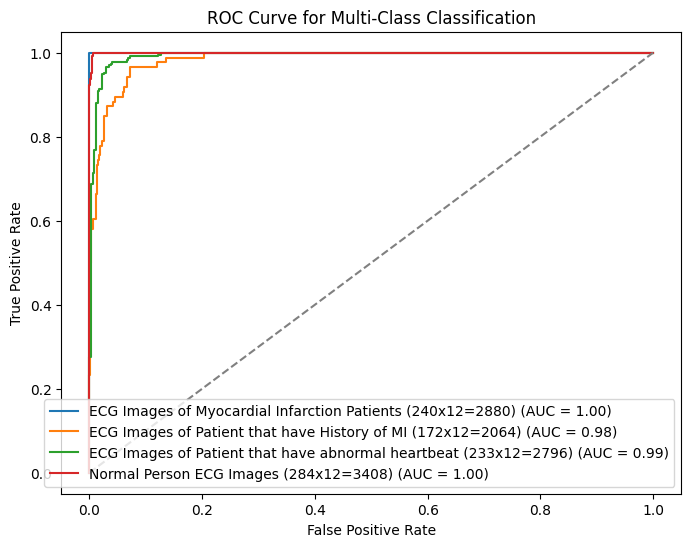

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import itertools

# Function to compute ROC & AUC
def plot_roc_auc(model, data_loader, num_classes, class_names, device):
    model.eval()  # Set to evaluation mode
    y_true = []
    y_scores = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)  # Get probabilities

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    # Convert labels to one-hot encoding for multi-class ROC
    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

    # Random classifier line
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multi-Class Classification")
    plt.legend(loc="lower right")
    plt.show()

# Call the function after training
plot_roc_auc(model, test_loader, num_classes, train_dataset.classes, device)
